# Failure Data Analysis Pipeline

## Import Required Libraries

In [115]:
!pip install pandas numpy matplotlib seaborn tensorflow scikit-learn

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline
sns.set()

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading

In [117]:
# Load the dataset
data = pd.read_csv('failure.csv')

# Display initial information
print("Dataset Shape:", data.shape)
data.info()

Dataset Shape: (10081, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        7963 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


## Data Cleaning

In [118]:
def fahrenheit_to_celsius(temp):
    """
    Convert temperature to Celsius
    """
    if "°F" in str(temp):
        value = float(temp.replace(" °F", ""))
        return (value - 32) * 5.0 / 9.0
    elif "°C" in str(temp):
        return float(temp.replace(" °C", ""))
    else:
        return np.nan

# Clean temperature column
data['Temperature'] = data['Temperature'].apply(fahrenheit_to_celsius)

# Handle missing values
categorical_columns = ['Membership', 'Factory', 'Usage']
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Display cleaned data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  float64
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        10081 non-null  object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.1+ MB


## Feature Engineering

In [119]:
# Combine failure columns into a single target column
data["Failure"] = (
    data[["Failure A", "Failure B", "Failure C", "Failure D", "Failure E"]].sum(axis=1)
    > 0
).astype(int)

# One-hot encoding for categorical variables
categorical_columns = ["Model", "Factory", "Usage", "Membership"]
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Prepare features and target
X = data_encoded.drop(
    columns=[
        "Failure A",
        "Failure B",
        "Failure C",
        "Failure D",
        "Failure E",
        "Color",
        "Car ID",
        "Failure",
    ]
)
y = data_encoded["Failure"]  # Binary failure target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes
print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (8064, 51)
Testing data shape: (2017, 51)


In [120]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Car ID                    10081 non-null  object 
 1   Color                     10081 non-null  object 
 2   Temperature               10081 non-null  float64
 3   RPM                       10081 non-null  int64  
 4   Fuel consumption          10081 non-null  float64
 5   Failure A                 10081 non-null  int64  
 6   Failure B                 10081 non-null  int64  
 7   Failure C                 10081 non-null  int64  
 8   Failure D                 10081 non-null  int64  
 9   Failure E                 10081 non-null  int64  
 10  Failure                   10081 non-null  int32  
 11  Model_Model 3, 2010       10081 non-null  bool   
 12  Model_Model 3, 2011       10081 non-null  bool   
 13  Model_Model 3, 2012       10081 non-null  bool   
 14  Model_

## Data Visualization

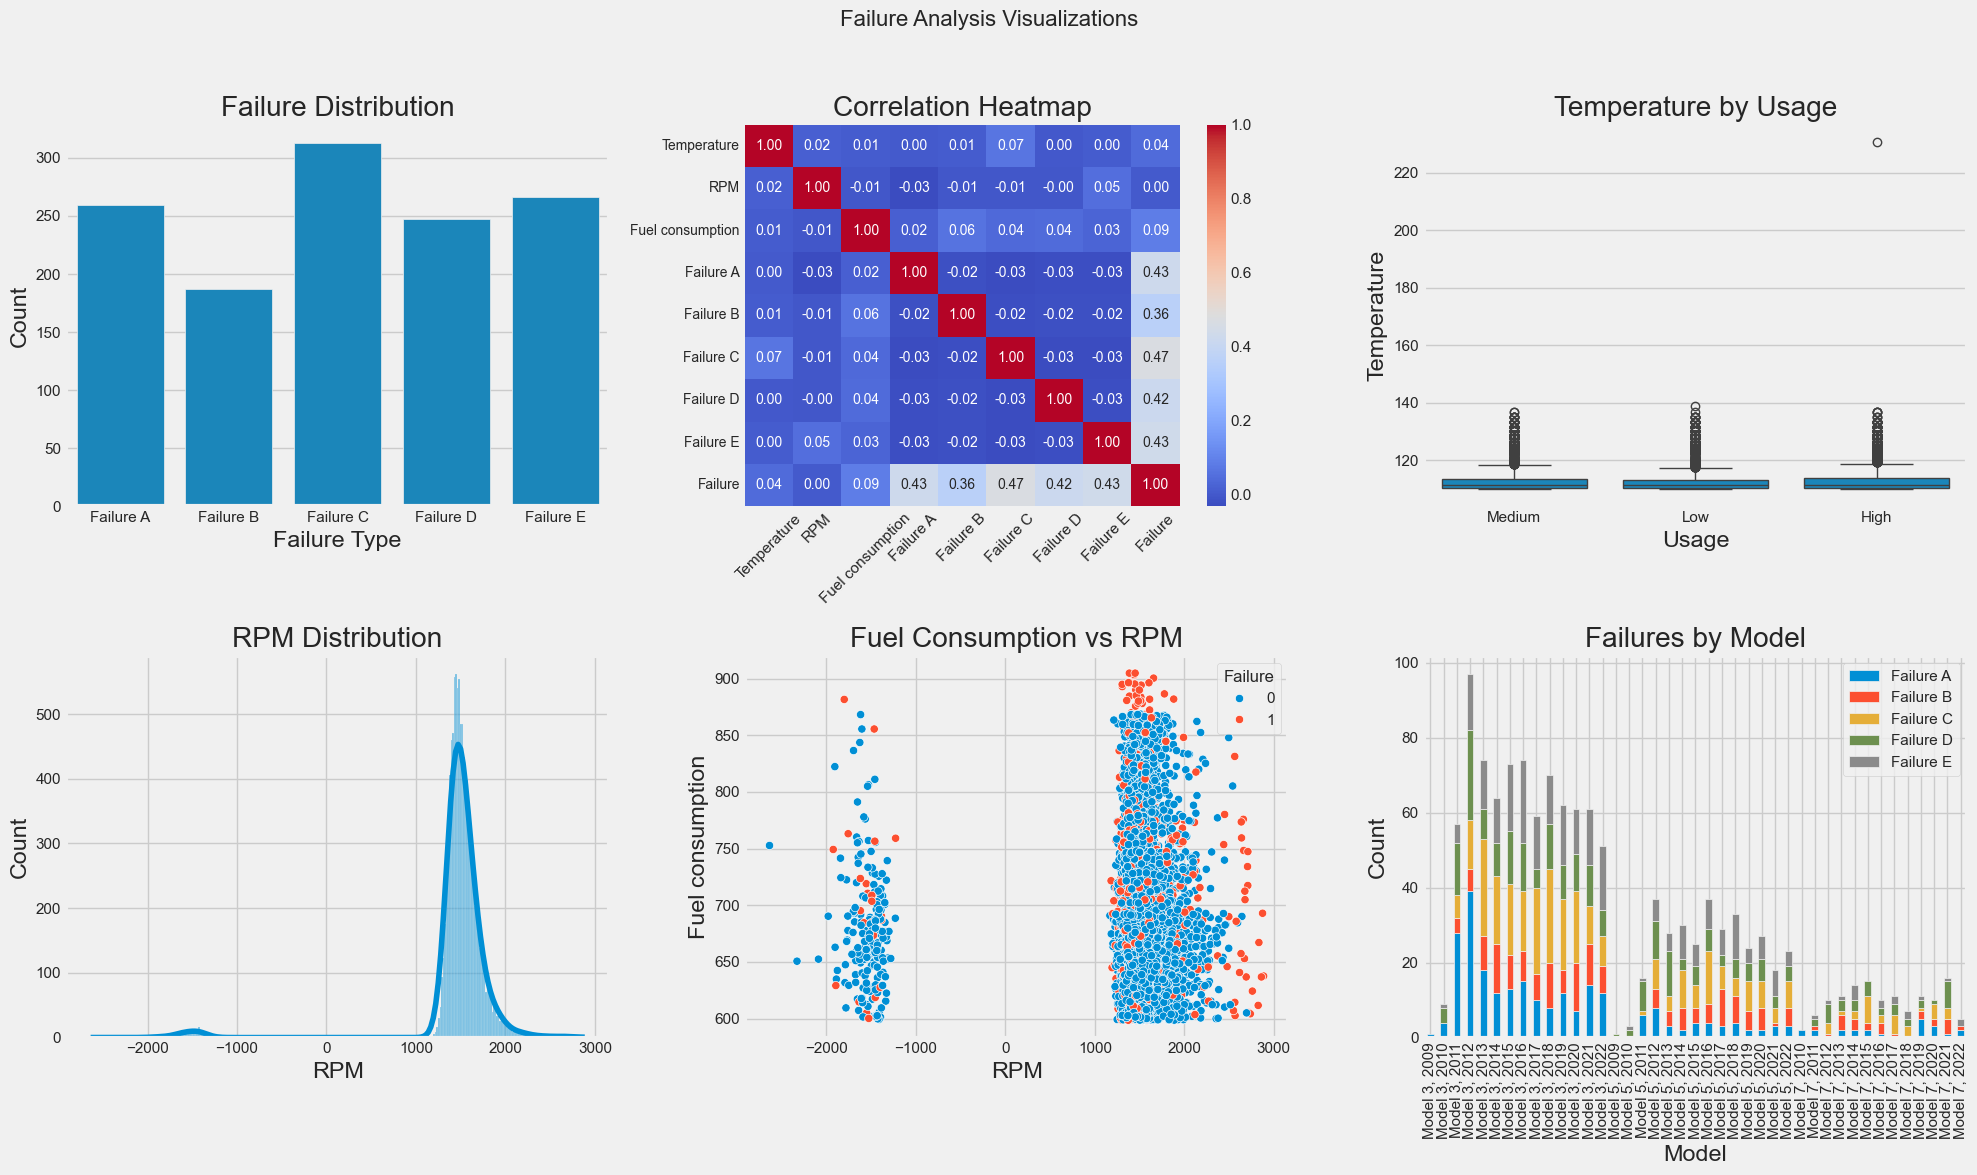

In [121]:
# Set plot style
plt.style.use('fivethirtyeight')

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Failure Analysis Visualizations', fontsize=16)

# 1. Failure Distribution
failure_columns = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']
failure_counts = data[failure_columns].sum()
sns.barplot(x=failure_counts.index, y=failure_counts.values, ax=axes[0, 0])
axes[0, 0].set_title('Failure Distribution')
axes[0, 0].set_xlabel('Failure Type')
axes[0, 0].set_ylabel('Count')

# 2. Correlation Heatmap
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation = data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10}, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Heatmap')
axes[0, 1].tick_params(axis='x', labelrotation=45)
axes[0, 1].tick_params(axis='y', labelsize=10)

# 3. Temperature by Usage
sns.boxplot(x='Usage', y='Temperature', data=data, ax=axes[0, 2])
axes[0, 2].set_title('Temperature by Usage')

# 4. RPM Distribution
sns.histplot(data['RPM'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('RPM Distribution')

# 5. Fuel Consumption Scatter
sns.scatterplot(x='RPM', y='Fuel consumption', hue='Failure', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Fuel Consumption vs RPM')

# 6. Model-wise Failure Analysis
failure_by_model = data.groupby('Model')[failure_columns].sum()
failure_by_model.plot(kind='bar', stacked=True, ax=axes[1, 2])
axes[1, 2].set_title('Failures by Model')
axes[1, 2].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Build and Train the Model

In [122]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Checkpoint to save best model
checkpoint = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50


C:\Users\Hassan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7004 - loss: 0.6293
Epoch 1: val_loss improved from inf to 0.35049, saving model to best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7131 - loss: 0.6137 - val_accuracy: 0.8810 - val_loss: 0.3505
Epoch 2/50
200/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.3741
Epoch 2: val_loss improved from 0.35049 to 0.32928, saving model to best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8790 - loss: 0.3740 - val_accuracy: 0.8865 - val_loss: 0.3293
Epoch 3/50
178/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.3415
Epoch 3: val_loss improved from 0.32928 to 0.32489, saving model to best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8844 - loss: 0.3424 - val_accuracy: 0.8865 - val_loss: 0.3249
Epoch 4/50
186/202 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8842 - loss: 0.3488
Epoch 4: val_loss improved from 0.32489 to 0.32290, saving model 

## Evaluate the Model

In [123]:
# Load the best weights
model.load_weights('best_model.keras')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.90


# Use The Model

In [131]:
# Function to test the trained model on new Random data
def test_model_usage(input_data):

    # Convert the input data to a DataFrame for consistency with the training data
    input_df = pd.DataFrame([input_data])

    # One-hot encode categorical columns (same as done during training)
    categorical_columns = ["Model", "Factory", "Usage", "Membership"]
    input_df_encoded = pd.get_dummies(
        input_df, columns=categorical_columns, drop_first=True
    )

    # Ensure the input data has the same columns as the training data
    input_df_encoded = input_df_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Scale the input data (same as done during training)
    input_scaled = scaler.transform(input_df_encoded)

    # Make a prediction using the trained model
    prediction = model.predict(input_scaled)

    # Return the result based on the prediction threshold
    return "Failure" if prediction[0] > 0.5 else "No Failure"

# Sample new data for testing the function
sample_new = data.sample(1).iloc[0]  # Get a single sample row

# Create a dictionary for the new data input
new_data = {
    "Model": sample_new["Model"],
    "Factory": sample_new["Factory"],
    "Usage": sample_new["Usage"],
    "Membership": sample_new["Membership"],
    "Temperature": sample_new["Temperature"],  # Temperature in Celsius
    "RPM": sample_new["RPM"],
    "Fuel consumption": sample_new["Fuel consumption"],
}

# Example usage:
result = test_model_usage(new_data)
print("Prediction for the new data:", result)

print(sample_new)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for the new data: Failure
Car ID              facf1ac3-5229-4bfb-90ac-e69fb19c9cb7
Model                                      Model 3, 2022
Color                                              Black
Temperature                                   110.333333
RPM                                                 1716
Factory                                    New York, U.S
Usage                                             Medium
Fuel consumption                                   685.2
Membership                                       Premium
Failure A                                              0
Failure B                                              0
Failure C                                              0
Failure D                                              0
Failure E                                              0
Failure                                                0
Name: 1922, dtype: object
